#Data Preparation

In [232]:
pip install twitter

In [233]:
import numpy as np
import pandas as pd
import re
import datetime
from nltk.stem.porter import *
from nltk.corpus import stopwords
from pandas.tseries import offsets
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import twitter
import time

In [234]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
air= pd.read_csv('/content/drive/MyDrive/758A: Text Mining/Three Topic Data/airlines_2.csv').drop(['Unnamed: 0'],axis=1)

In [236]:
oil=pd.read_csv('/content/drive/MyDrive/758A: Text Mining/Three Topic Data/oil_2.csv').drop('Unnamed: 0',axis=1)

In [237]:
retail=pd.read_csv('/content/drive/MyDrive/758A: Text Mining/Three Topic Data/retail_2.csv').drop(['Unnamed: 0'],axis=1)

In [238]:
text_data=pd.concat([air,oil,retail]).reset_index().drop('index',axis=1)

In [239]:
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta

In [240]:
text_data=text_data.dropna().reset_index(drop=True)

In [241]:
text_data['date']=pd.to_datetime(text_data['date'])

In [242]:
text_data

,date,text,topic
0,2019-11-04,Transits are a breeze with #AirChina’s baggage...,airlines
1,2019-11-03,#KnowBeforeYouGo #TravelTips Losing your board...,airlines
2,2019-11-02,#ExploreChina The glittering lights of #Shangh...,airlines
3,2019-11-02,#AirChina ’s launched another new route! Can y...,airlines
4,2019-11-01,144-hour visa-free transit is now available in...,airlines
...,...,...,...
6524,2019-12-16,Name your favorite Christmas movie. (wrong ans...,retail
6525,2019-12-13,Who's the hardest person to find a gift for?,retail
6526,2019-12-12,Cold weather have you down? Tell us what you'r...,retail
6527,2019-12-11,Raise your hand if you haven't started gift sh...,retail


In [243]:
text_data.to_csv('final_data2.csv')

#Data Cleaning

Open CSV file using a Pandas dataframe
Create a new where the date column in your CSV is transformed to a Pandas datetime object
Create a new column which lower-cases and filters out the following from the text:
Punctuation
Numbers
Syntax, XML, HTML

In [244]:
text_data['date'][1]

Timestamp('2019-11-03 00:00:00')

In [245]:
def clean_text(text):
    new_text = text.lower()
    new_text = re.sub('http[s]*://[a-z0-9.!@#$%^&*?_/=:\-+~`]*','',new_text)
    new_text = re.sub("[^a-z]"," ", new_text)
    return new_text

text_data['new_text'] = text_data['text'].apply(clean_text)
text_data.head()

,date,text,topic,new_text
0,2019-11-04,Transits are a breeze with #AirChina’s baggage...,airlines,transits are a breeze with airchina s baggage...
1,2019-11-03,#KnowBeforeYouGo #TravelTips Losing your board...,airlines,knowbeforeyougo traveltips losing your board...
2,2019-11-02,#ExploreChina The glittering lights of #Shangh...,airlines,explorechina the glittering lights of shangh...
3,2019-11-02,#AirChina ’s launched another new route! Can y...,airlines,airchina s launched another new route can y...
4,2019-11-01,144-hour visa-free transit is now available in...,airlines,hour visa free transit is now available in...


#Topic Modeling

##Create a new column which tokenizes the text, lemmatizes each token and removes any stop words (i.e. it should be a list in the end)

In [246]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [247]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [248]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We deleted some meaningless words ourselves to optimize our result

In [256]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk import pos_tag
import nltk
from nltk.corpus import wordnet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
from nltk.corpus import stopwords
sw = set(stopwords.words("english"))
sw.add('rt')
sw.add('thi')
sw.add('day')
sw.add('new')
sw.add('one')
sw.add('make')
sw.add('get')

def generate_tokens(text):
    tokens = text.split()
    tokens = [stemmer.stem(el) for el in tokens]
    tokens_pos = nltk.pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(el[0],get_wordnet_pos(el[1])) for  el in tokens_pos]
    tokens = [el for el in tokens if el not in sw]
    return tokens

text_data['tokens'] = text_data['new_text'].apply(generate_tokens)
text_data['clean_text'] = [' '.join(text_data.tokens[i]) for i in range(0,len(text_data))]
text_data.head()

,date,text,topic,new_text,tokens,clean_text
0,2019-11-04,Transits are a breeze with #AirChina’s baggage...,airlines,transits are a breeze with airchina s baggage...,"[transit, breez, airchina, baggag, check, serv...",transit breez airchina baggag check servic col...
1,2019-11-03,#KnowBeforeYouGo #TravelTips Losing your board...,airlines,knowbeforeyougo traveltips losing your board...,"[knowbeforeyougo, traveltip, lose, board, pas,...",knowbeforeyougo traveltip lose board pas night...
2,2019-11-02,#ExploreChina The glittering lights of #Shangh...,airlines,explorechina the glittering lights of shangh...,"[explorechina, glitter, light, shanghai, world...",explorechina glitter light shanghai world famo...
3,2019-11-02,#AirChina ’s launched another new route! Can y...,airlines,airchina s launched another new route can y...,"[airchina, launch, anoth, rout, guess, share, ...",airchina launch anoth rout guess share guess c...
4,2019-11-01,144-hour visa-free transit is now available in...,airlines,hour visa free transit is now available in...,"[hour, visa, free, transit, avail, dozen, citi...",hour visa free transit avail dozen citi across...


##Estimate a 3-topic Topic Model

###Create word clouds for each topic.

In [257]:
tweets_tokens = text_data.tokens.values
common_dictionary = Dictionary(tweets_tokens)
common_corpus = [common_dictionary.doc2bow(text) for text in tweets_tokens]

lda = LdaModel(common_corpus, num_topics = 3, 
              id2word = common_dictionary, passes = 5,
              random_state = 1234)

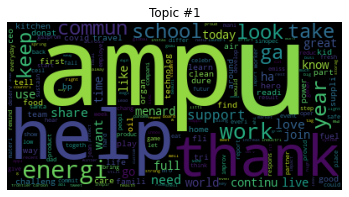

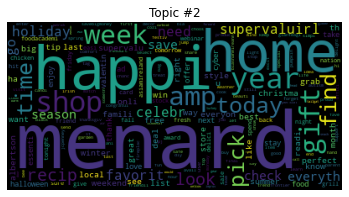

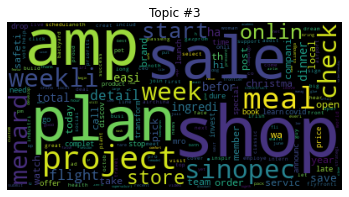

In [258]:
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    plt.savefig("Topic_"+ str(t+1)+".png")

##Query the documents (if using newspaper or speeches, be sure to concatenate articles by article-time or president-time) and compute the document-topic proportions.

In [259]:
import datetime

Monthly

We do it monthly since the trend will be more obvious and less violate

In [260]:
text_data['year_month'] = [text_data.date[i].strftime('%Y-%m') for i in range(0,len(text_data))]
tweet_agg = text_data.groupby(['topic',"year_month"]).tokens.agg(sum).reset_index()
tweet_agg.head()

,topic,year_month,tokens
0,airlines,2018-12,"[xi, come, lo, angel, flyhainan, flyhainan, de..."
1,airlines,2019-01,"[flyhainan, readi, chine, year, happi, wingwed..."
2,airlines,2019-02,"[launch, two, time, weekli, servic, tel, aviv,..."
3,airlines,2019-03,"[fwc, week, celebr, fortun, wing, club, th, bi..."
4,airlines,2019-04,"[great, shot, relax, take, creativ, inflight, ..."


In [262]:
tweet_tokens_agg = tweet_agg.tokens.values
common_dictionary_agg = Dictionary(tweet_tokens_agg)
common_corpus_agg = [common_dictionary.doc2bow(text) for text in tweet_tokens_agg]

topic_props = [lda.get_document_topics(doc,minimum_probability=0) for doc in common_corpus_agg]
topic_props_df = pd.DataFrame(topic_props)
topic_props_df.head()

for each in topic_props_df.columns:
    tweet_agg[each] = topic_props_df[each].apply(lambda x: x[1])
tweet_agg.head()

,topic,year_month,tokens,0,1,2
0,airlines,2018-12,"[xi, come, lo, angel, flyhainan, flyhainan, de...",0.350737,0.237587,0.411676
1,airlines,2019-01,"[flyhainan, readi, chine, year, happi, wingwed...",0.405561,0.164266,0.430173
2,airlines,2019-02,"[launch, two, time, weekli, servic, tel, aviv,...",0.006982,0.438266,0.554753
3,airlines,2019-03,"[fwc, week, celebr, fortun, wing, club, th, bi...",0.275927,0.206391,0.517682
4,airlines,2019-04,"[great, shot, relax, take, creativ, inflight, ...",0.360671,0.229796,0.409533


###Save the document-topic matrix as a csv

In [263]:
tweet_agg.to_csv('tweet_agg.csv', sep=',', header=True, index=True)

In [264]:
tweet_agg['year_month']=pd.to_datetime(tweet_agg['year_month'])

###How do topics change over time?

In [275]:
datetime.datetime(2019,10,3)

datetime.datetime(2019, 10, 3, 0, 0)

We choose the common time period to study

In [278]:
tweet_agg=tweet_agg[tweet_agg['year_month']>datetime.datetime(2019,10,3)]

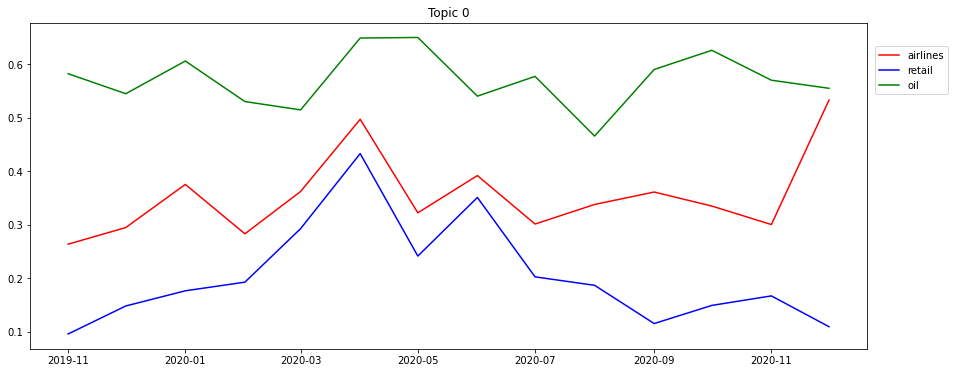

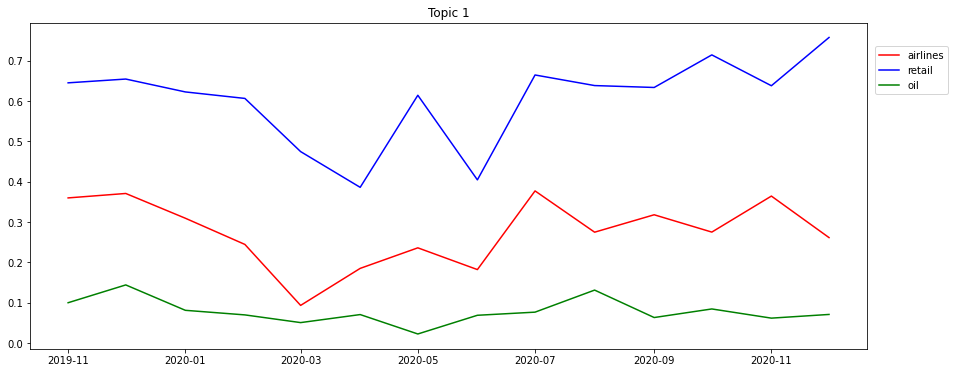

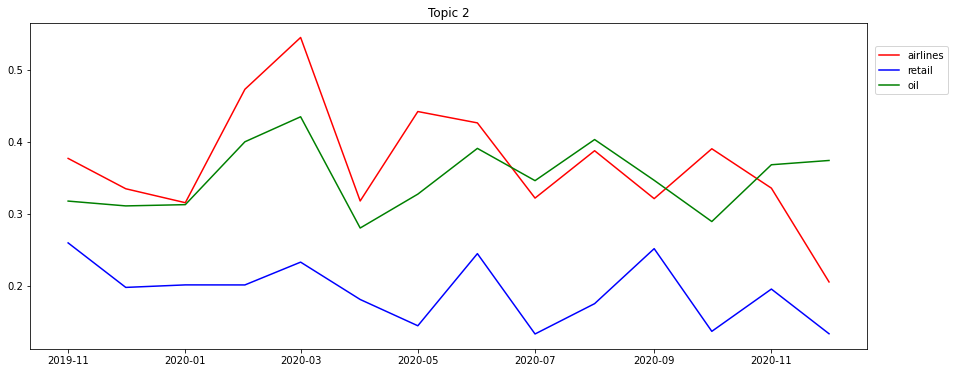

In [279]:
tweet_agg.sort_values(["topic","year_month"])

airlines = tweet_agg[tweet_agg.topic=="airlines"]
retail = tweet_agg[tweet_agg.topic=="retail"]
oil = tweet_agg[tweet_agg.topic=="oil"]

for i in range(0,3):
    plt.figure(figsize=(15,6))
    plt.plot(airlines["year_month"], airlines[i], "r-", label="airlines")
    plt.plot(retail["year_month"], retail[i], "b-", label="retail")
    plt.plot(oil["year_month"], oil[i], "g-", label="oil")
    plt.legend(bbox_to_anchor=(1.01, 0.78), loc=3, borderaxespad=0)
    plt.title('Topic ' + str(i))
    plt.show()

##Repeat step 5 using a topic model with some K between 5-25. What do you notice?

we use K equals to 6, since we think each industry might has multiple topics in their tweets and they might be correlated with each other (not independent with each other). For example, tweets from airline companies might about discount information, award, weather conditions and also the data from airline industry can also reflect information about covid .

In [280]:
tweets_tokens_new = text_data.tokens.values
common_dictionary_new = Dictionary(tweets_tokens_new)
common_corpus_new = [common_dictionary_new.doc2bow(text) for text in tweets_tokens_new]

lda_new = LdaModel(common_corpus_new, num_topics = 6, 
              id2word = common_dictionary_new, passes = 5,
              random_state = 1234)

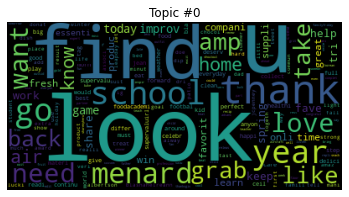

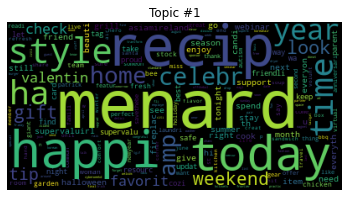

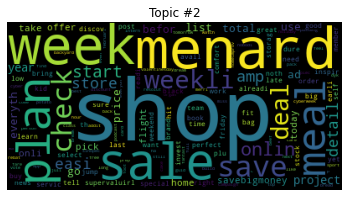

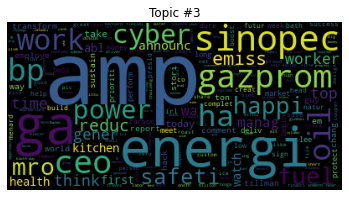

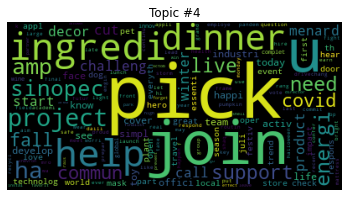

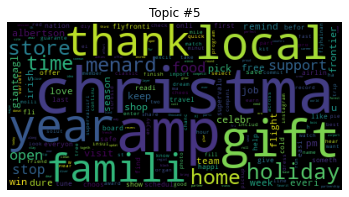

In [281]:
for t in range(lda_new.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_new.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig("Topic_"+ str(t)+".png")

In [282]:

tweet_agg_new = text_data.groupby(['topic',"year_month"]).tokens.agg(sum).reset_index()

tweet_tokens_agg_new = tweet_agg_new.tokens.values
common_dictionary_agg__new = Dictionary(tweet_tokens_agg_new)
common_corpus_agg_new = [common_dictionary_new.doc2bow(text) for text in tweet_tokens_agg_new]

topic_props_new = [lda_new.get_document_topics(doc,minimum_probability=0) for doc in common_corpus_agg_new]
topic_props_df_new = pd.DataFrame(topic_props_new)
topic_props_df_new.head()

for each in topic_props_df_new.columns:
    tweet_agg_new[each] = topic_props_df_new[each].apply(lambda x: x[1])

tweet_agg_new.head()

,topic,year_month,tokens,0,1,2,3,4,5
0,airlines,2018-12,"[xi, come, lo, angel, flyhainan, flyhainan, de...",0.182620,0.084098,0.131536,0.000387,0.068186,0.533172
1,airlines,2019-01,"[flyhainan, readi, chine, year, happi, wingwed...",0.207205,0.075839,0.193189,0.025383,0.028093,0.470290
2,airlines,2019-02,"[launch, two, time, weekli, servic, tel, aviv,...",0.002638,0.339389,0.364728,0.047995,0.175387,0.069863
3,airlines,2019-03,"[fwc, week, celebr, fortun, wing, club, th, bi...",0.300776,0.160209,0.370444,0.000893,0.116936,0.050742
4,airlines,2019-04,"[great, shot, relax, take, creativ, inflight, ...",0.283378,0.098125,0.140063,0.152108,0.136390,0.189936


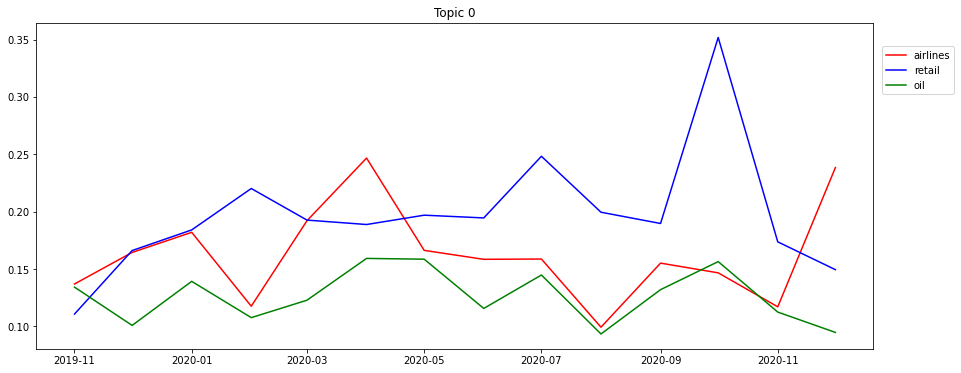

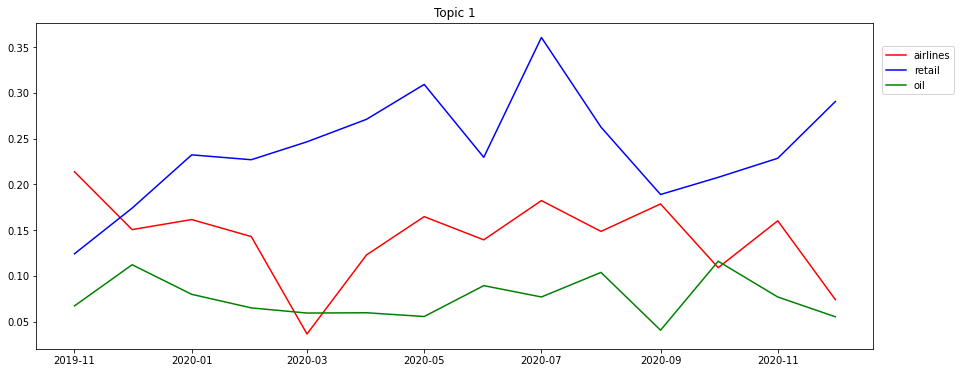

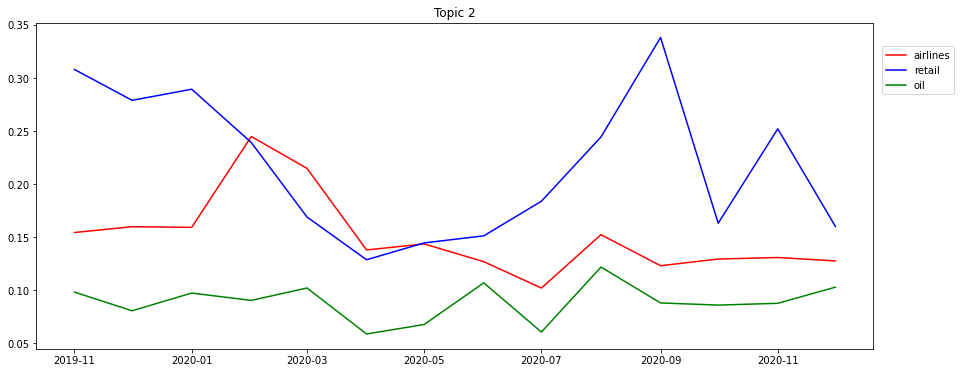

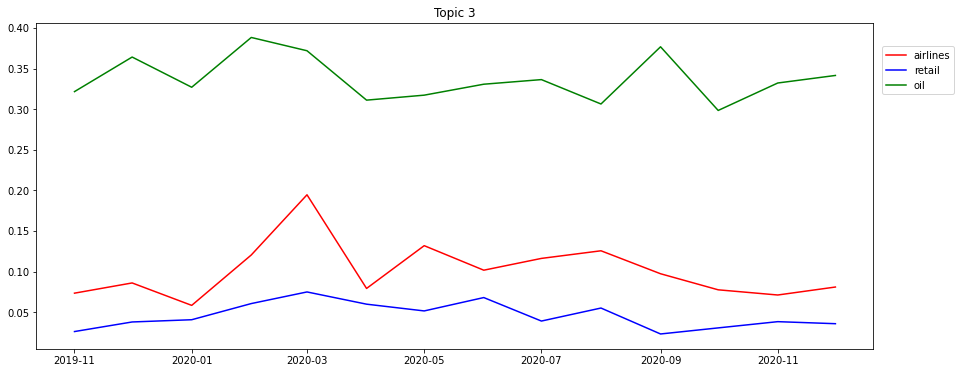

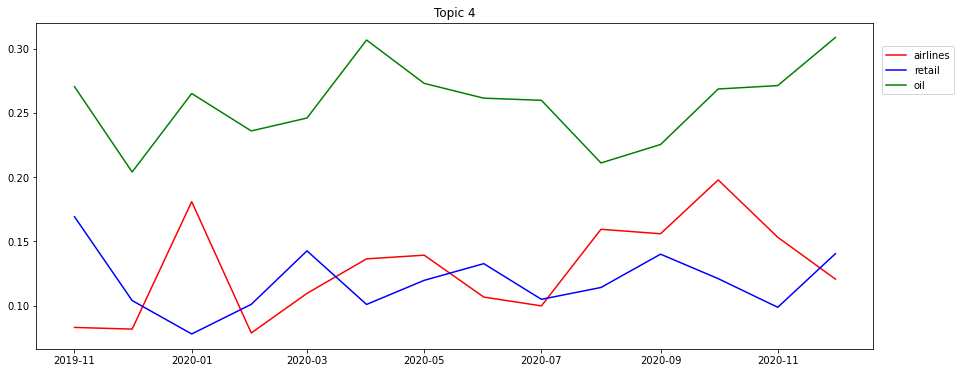

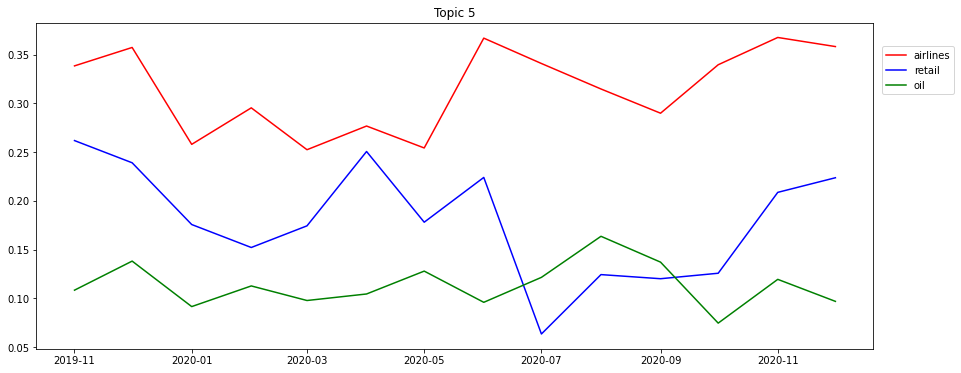

In [285]:
tweet_agg_new.to_csv('tweet_agg_new.csv', sep=',', header=True, index=True)
tweet_agg_new.sort_values(["topic","year_month"])
tweet_agg_new['year_month']=pd.to_datetime(tweet_agg_new['year_month'])
tweet_agg_new=tweet_agg_new[tweet_agg_new['year_month']>datetime.datetime(2019,10,3)]


airlines_new = tweet_agg_new[tweet_agg_new.topic=="airlines"]
retail_new = tweet_agg_new[tweet_agg_new.topic=="retail"]
oil_new = tweet_agg_new[tweet_agg_new.topic=="oil"]

for i in range(0,6):
    plt.figure(figsize=(15,6))
    plt.plot(airlines_new["year_month"], airlines_new[i], "r-", label="airlines")
    plt.plot(retail_new["year_month"], retail_new[i], "b-", label="retail")
    plt.plot(oil_new["year_month"], oil_new[i], "g-", label="oil")
    plt.legend(bbox_to_anchor=(1.01, 0.78), loc=3, borderaxespad=0)
    plt.title('Topic ' + str(i))
    plt.show()

##Find 5 new documents (of at least 10 words) which are “unseen” by your topic model and estimate the document-topic proportions. You may find a tweet, newspaper article, etc. to input into your model. Does it accurately pick up topic proportions?

In [320]:
test_new = pd.read_csv("/content/drive/MyDrive/758A: Text Mining/test_data.csv",encoding= 'unicode_escape').drop('Unnamed: 0',axis=1)
test_new

,date,text,topic
0,11/20/2020,The results for the 2020 TPG Readers Choice A...,airlines
1,10/29/2020,They also found that ventilation systems onboa...,airlines
2,5/28/2020,A community in Indias COVID-19 lockdown. Resi...,oil
3,11/12/2020,US crude oil inventories for the week ended No...,oil
4,11/27/2020,"ETRetail | From turnover point of view, we are...",retail
5,11/25/2020,Dave Kimbell discusses how the beauty retailer...,retail


In [326]:
test_new['new_text'] = test_new['text'].apply(clean_text)
test_new['tokens'] = test_new['new_text'].apply(generate_tokens)
test_new['clean_text'] = [' '.join(test_new.tokens[i]) for i in range(0,len(test_new))]
test_new['year_month'] = [datetime.datetime.strptime(test_new.date[i],'%m/%d/%Y').strftime('%Y-%m') for i in range(0,len(test_new))]
test_new['date']=pd.to_datetime(test_new['date'])
test_new.head()

,date,text,topic,new_text,tokens,clean_text,year_month
0,2020-11-20,The results for the 2020 TPG Readers Choice A...,airlines,the results for the tpg reader s choice a...,"[result, tpg, reader, choic, award, peopl, spe...",result tpg reader choic award peopl speak hono...,2020-11
1,2020-10-29,They also found that ventilation systems onboa...,airlines,they also found that ventilation systems onboa...,"[also, find, ventil, system, onboard, good, ef...",also find ventil system onboard good effect co...,2020-10
2,2020-05-28,A community in Indias COVID-19 lockdown. Resi...,oil,a community in india s covid lockdown resi...,"[commun, india, covid, lockdown, resid, migran...",commun india covid lockdown resid migrant work...,2020-05
3,2020-11-12,US crude oil inventories for the week ended No...,oil,us crude oil inventories for the week ended no...,"[u, crude, oil, inventori, week, end, nov, exc...",u crude oil inventori week end nov exclud stra...,2020-11
4,2020-11-27,"ETRetail | From turnover point of view, we are...",retail,etretail from turnover point of view we are...,"[etretail, turnov, point, view, alreadi, back,...",etretail turnov point view alreadi back pre co...,2020-11


In [329]:
test_agg_new = test_new.groupby(['topic',"year_month"]).tokens.agg(sum).reset_index()
test_agg_new

,topic,year_month,tokens
0,airlines,2020-10,"[also, find, ventil, system, onboard, good, ef..."
1,airlines,2020-11,"[result, tpg, reader, choic, award, peopl, spe..."
2,oil,2020-05,"[commun, india, covid, lockdown, resid, migran..."
3,oil,2020-11,"[u, crude, oil, inventori, week, end, nov, exc..."
4,retail,2020-11,"[etretail, turnov, point, view, alreadi, back,..."


### Use the model with k = 3 to estimate the document-topic proportions.

In [331]:
test_tokens_new = test_new.tokens.values
common_dictionary_new = Dictionary(test_tokens_new)
common_corpus_new = [common_dictionary_new.doc2bow(text) for text in test_tokens_new]

test_tokens_agg_new = test_agg_new.tokens.values
common_dictionary_agg_new = Dictionary(test_tokens_agg_new)
common_corpus_agg_new = [common_dictionary_new.doc2bow(text) for text in test_tokens_agg_new]

topic_props_new = [lda.get_document_topics(doc,minimum_probability=0) for doc in common_corpus_agg_new]
topic_props_new_df = pd.DataFrame(topic_props_new)

for each in topic_props_new_df.columns:
    test_agg_new[each] = topic_props_new_df[each].apply(lambda x: x[1])
test_agg_new

,topic,year_month,tokens,0,1,2
0,airlines,2020-10,"[also, find, ventil, system, onboard, good, ef...",0.544954,0.026251,0.428795
1,airlines,2020-11,"[result, tpg, reader, choic, award, peopl, spe...",0.353528,0.016202,0.630270
2,oil,2020-05,"[commun, india, covid, lockdown, resid, migran...",0.171124,0.351351,0.477525
3,oil,2020-11,"[u, crude, oil, inventori, week, end, nov, exc...",0.175614,0.343257,0.481129
4,retail,2020-11,"[etretail, turnov, point, view, alreadi, back,...",0.365939,0.443242,0.190818


### Use the model with k = 6 to estimate the document-topic proportions.

In [332]:
topic_props_new_6 = [lda_new.get_document_topics(doc,minimum_probability=0) for doc in common_corpus_agg_new]
topic_props_new_df_6 = pd.DataFrame(topic_props_new_6)

for each in topic_props_new_df_6.columns:
    test_agg_new[each] = topic_props_new_df_6[each].apply(lambda x: x[1])
test_agg_new

,topic,year_month,tokens,0,1,2,3,4,5
0,airlines,2020-10,"[also, find, ventil, system, onboard, good, ef...",0.446972,0.011951,0.012005,0.239302,0.012068,0.277700
1,airlines,2020-11,"[result, tpg, reader, choic, award, peopl, spe...",0.172748,0.007617,0.258799,0.059030,0.142236,0.359571
2,oil,2020-05,"[commun, india, covid, lockdown, resid, migran...",0.316804,0.085110,0.332749,0.008788,0.008850,0.247700
3,oil,2020-11,"[u, crude, oil, inventori, week, end, nov, exc...",0.194865,0.008391,0.408402,0.008369,0.103992,0.275981
4,retail,2020-11,"[etretail, turnov, point, view, alreadi, back,...",0.085857,0.420345,0.137520,0.005961,0.052434,0.297884


#Word Embeddings

## 8. Create a new column which now simply removes punctuation, lower-cases, and tokenizes each sentence (Do not stem or lemmatize). Thus, each element of this new column should be a list of lists (e.g. [[“this”,”is”,”the”,”first”,”sentence”],[“this”,”is”,”the”,”second”,”sentence”],…]

In [333]:
def simply_clean(text):
    new_text = text.lower()
    new_text = re.sub('http[s]*://[a-z0-9.!@#$%^&*?_/=:\-+~`]*','',new_text)
    new_text = re.sub("[^a-z]"," ", new_text)
    return new_text

text_data['simply_clean'] = text_data['text'].apply(simply_clean)
text_data['simply_tokens'] = text_data.simply_clean.apply(lambda x: [x.split()])
text_data.head()

,date,text,topic,new_text,tokens,clean_text,year_month,simply_clean,simply_tokens
0,2019-11-04,Transits are a breeze with #AirChina’s baggage...,airlines,transits are a breeze with airchina s baggage...,"[transit, breez, airchina, baggag, check, serv...",transit breez airchina baggag check servic col...,2019-11,transits are a breeze with airchina s baggage...,"[[transits, are, a, breeze, with, airchina, s,..."
1,2019-11-03,#KnowBeforeYouGo #TravelTips Losing your board...,airlines,knowbeforeyougo traveltips losing your board...,"[knowbeforeyougo, traveltip, lose, board, pas,...",knowbeforeyougo traveltip lose board pas night...,2019-11,knowbeforeyougo traveltips losing your board...,"[[knowbeforeyougo, traveltips, losing, your, b..."
2,2019-11-02,#ExploreChina The glittering lights of #Shangh...,airlines,explorechina the glittering lights of shangh...,"[explorechina, glitter, light, shanghai, world...",explorechina glitter light shanghai world famo...,2019-11,explorechina the glittering lights of shangh...,"[[explorechina, the, glittering, lights, of, s..."
3,2019-11-02,#AirChina ’s launched another new route! Can y...,airlines,airchina s launched another new route can y...,"[airchina, launch, anoth, rout, guess, share, ...",airchina launch anoth rout guess share guess c...,2019-11,airchina s launched another new route can y...,"[[airchina, s, launched, another, new, route, ..."
4,2019-11-01,144-hour visa-free transit is now available in...,airlines,hour visa free transit is now available in...,"[hour, visa, free, transit, avail, dozen, citi...",hour visa free transit avail dozen citi across...,2019-11,hour visa free transit is now available in...,"[[hour, visa, free, transit, is, now, availabl..."


##Generate 300-dimensional word embeddings using a window size of 5

We set sg = 1 here, and we want to use the target word to predict the context words in this case.

We set the window = 5.

We set the negative sampling rate to 10 sample word here, in order to improve our modeling efficiency and improve the quality of the resulting word vector.

In [334]:
model = Word2Vec(text_data["simply_tokens"].sum(), size=300, sg=1, window=5, min_count=5, negative=10, seed=1233, workers=1)

##Pick 3 interesting words. Find the 10 words which are closest to each of these 3 words. How accurate do you find the results?

In [335]:
interest_words = ['journey','food','covid']

clean_interest_words = [simply_clean(interest_words[i]) for i in range(0,len(interest_words))]

word_similar = [model.wv.most_similar(positive=[el], topn=10) for el in clean_interest_words]
word_similar_df = pd.DataFrame(word_similar)
word_similar_df

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,0,1,2,3,4,5,6,7,8,9
0,"(difference, 0.9988831281661987)","(challenging, 0.998494029045105)","(smart, 0.9982280731201172)","(mission, 0.9975941181182861)","(others, 0.9974520206451416)","(traveling, 0.9973271489143372)","(wonderful, 0.9973224997520447)","(pasta, 0.9972947835922241)","(countdown, 0.9971538782119751)","(heroes, 0.9970998764038086)"
1,"(winco, 0.9969470500946045)","(pittsburgh, 0.9940657019615173)","(me, 0.9930230379104614)","(marketdistrict, 0.9924603700637817)","(cake, 0.9923657178878784)","(fill, 0.9921647906303406)","(card, 0.9917173385620117)","(coming, 0.9916040301322937)","(resource, 0.9912983179092407)","(grocery, 0.9910831451416016)"
2,"(being, 0.9894440174102783)","(business, 0.986566424369812)","(employees, 0.9847409129142761)","(customers, 0.9826825857162476)","(partnership, 0.9818992614746094)","(k, 0.9813299775123596)","(top, 0.9813277721405029)","(partners, 0.9801875948905945)","(donated, 0.9794477224349976)","(service, 0.9791809916496277)"


The result is some how accurate since for the words related to "journey", there are some like traveling,pasta.... while words like "heros","difference" are confusing.

for words similar to "food", words like marketdistrict, cake are more reasonable.

for words similar to "covid", we can find business, employees, service which may indicate that covid has brought big influence into industries.


##Use a dimension reduction tool to project the 300-dimensional word embeddings onto a two-dimensional plane. Plot the word embeddings and label a few of the points (at least 10)

In [336]:
# Get list of words for annotation of the scatter plot
vocab = list(model.wv.vocab)
X = model[vocab]

# Project them onto the 2 Dimensional space
tsne = TSNE(n_components=2, random_state=1234)
X_tsne = tsne.fit_transform(X)
# Create a DataFrame with words as index, and
# 2 dimensions as main columns (x-axis, y-axis)
scatter_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


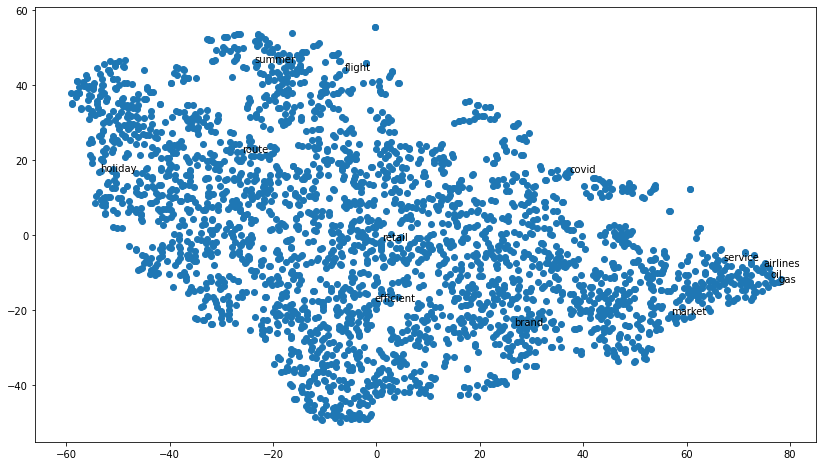

In [347]:
# Plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_df['x'], scatter_df['y'])

label_words = ['airlines','retail','oil','route','brand','efficient','gas','holiday','summer','flight','covid','service','market']
    
for word in label_words:
    pos = scatter_df.loc[word]
    ax.annotate(word, pos)
plt.show()

##Generate 10 interesting word relationships using the 300-dimensional word embeddings (analogies or vector additions)

In [351]:
print(model.wv.most_similar(positive=["oil",'airlines','retail'],negative=["covid"],topn=5))
print(model.wv.most_similar(positive=["airlines",'route','popular'],topn=5))
print(model.wv.most_similar(positive=["retail",'discounts','brand'],negative=["covid"],topn=5))
print(model.wv.most_similar(positive=["retail",'popular','holiday'],topn=5))
print(model.wv.most_similar(positive=["oil",'technology'],topn=5))
print(model.wv.most_similar(positive=["market"],negative=["covid"],topn=5))
print(model.wv.most_similar(positive=["top","retail"],topn=5))
print(model.wv.most_similar(positive=["top","oil"],topn=5))
print(model.wv.most_similar(positive=["airlines","efficient"],negative=["oil"], topn=5))
print(model.wv.most_similar(positive=["travel","oil"],negative=["shell"], topn=5))

[('lng', 0.9859542846679688), ('international', 0.982568621635437), ('turkish', 0.9801250696182251), ('china', 0.9798892736434937), ('natural', 0.9798010587692261)]
[('opening', 0.9983466267585754), ('pilot', 0.9982947111129761), ('wind', 0.998192310333252), ('leadership', 0.9980661273002625), ('india', 0.9978624582290649)]
[('hit', 0.9957945346832275), ('grill', 0.9951733350753784), ('fave', 0.9949776530265808), ('nature', 0.9948557019233704), ('answer', 0.9946325421333313)]
[('gets', 0.9994721412658691), ('manage', 0.9994115233421326), ('definitely', 0.9993974566459656), ('brilliant', 0.9993956685066223), ('everybody', 0.999394953250885)]
[('cooperation', 0.9966572523117065), ('petrochemical', 0.9964803457260132), ('lng', 0.9964480996131897), ('discuss', 0.9962680339813232), ('ltd', 0.9956526160240173)]
[('your', 0.48755648732185364), ('when', 0.4582137167453766), ('it', 0.4493701159954071), ('time', 0.4417595863342285), ('or', 0.43503063917160034)]
[('lines', 0.9989122152328491), ('

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


##Repeat Steps 9-12 using a choosing a different window size or dimension (use the same 3 words in Step 10 and the same relationships in Step 12). Do these word embeddings produce different words that are nearest to the 3 you chose in Step 10, a different graph to that in Step 11, and the same relationships you found in Step 12?

We change the window size to 10

In [353]:
model_new = Word2Vec(text_data["simply_tokens"].sum(), size=300, sg=1, window=10, min_count=5, negative=10, seed=1234, workers=1)

In [354]:
word_similar_new = [model_new.wv.most_similar(positive=[el], topn=10) for el in clean_interest_words]
word_similar_new_df = pd.DataFrame(word_similar_new)
word_similar_new_df

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,0,1,2,3,4,5,6,7,8,9
0,"(difference, 0.9944175481796265)","(mental, 0.9931455254554749)","(mission, 0.9930025935173035)","(used, 0.9929753541946411)","(challenging, 0.9928289651870728)","(countries, 0.9925006031990051)","(professionals, 0.9917061924934387)","(healthy, 0.9916645288467407)","(preparing, 0.990692138671875)","(achieve, 0.9905678033828735)"
1,"(businesses, 0.9849997162818909)","(seeing, 0.9843842387199402)","(real, 0.9839445948600769)","(lovely, 0.983229398727417)","(glad, 0.9829114675521851)","(long, 0.9823054075241089)","(such, 0.9821548461914062)","(warm, 0.9820961952209473)","(wow, 0.9817209243774414)","(neighbors, 0.9816545844078064)"
2,"(members, 0.9635464549064636)","(employees, 0.9580792784690857)","(being, 0.9427282810211182)","(efforts, 0.9351937174797058)","(committed, 0.9323579668998718)","(technology, 0.9219683408737183)","(across, 0.9218964576721191)","(board, 0.9212005138397217)","(operations, 0.9160943031311035)","(pandemic, 0.9153231382369995)"


reaults are different for similar words

In [355]:
# Get list of words for annotation of the scatter plot
vocab_new = list(model_new.wv.vocab)
X_new = model_new[vocab_new]

# Project them onto the 2 Dimensional space
tsne = TSNE(n_components=2,random_state=1234)
X_tsne_new = tsne.fit_transform(X_new)
# Create a DataFrame with words as index, and
# 2 dimensions as main columns (x-axis, y-axis)
scatter_new_df = pd.DataFrame(X_tsne_new, index=vocab_new, columns=['x', 'y'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


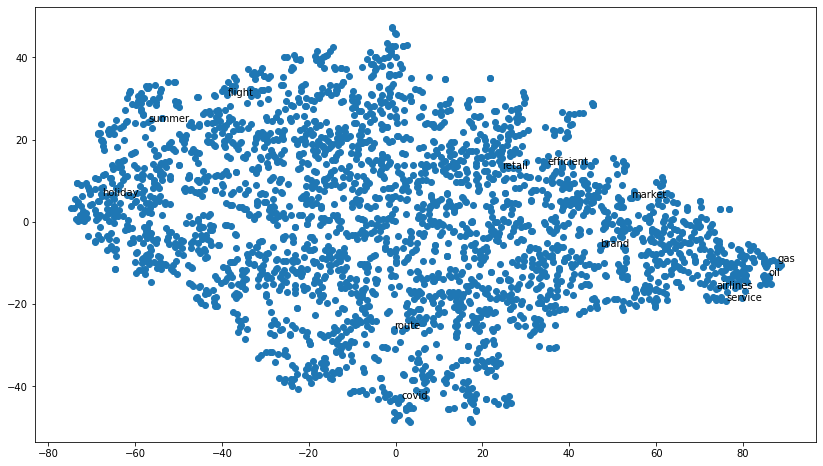

In [356]:
# Plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_new_df['x'], scatter_new_df['y'])

for word in label_words:
    pos = scatter_new_df.loc[word]
    ax.annotate(word, pos)
plt.show()

There are some similarity and difference at the same time. Difference lies on the position of covid, market and retail. But the plot is really similar to window size=5

In [357]:
print(model_new.wv.most_similar(positive=["oil",'airlines','retail'],negative=["covid"],topn=5))
print(model_new.wv.most_similar(positive=["airlines",'route','popular'],topn=5))
print(model_new.wv.most_similar(positive=["retail",'discounts','brand'],negative=["covid"],topn=5))
print(model_new.wv.most_similar(positive=["retail",'popular','holiday'],topn=5))
print(model_new.wv.most_similar(positive=["oil",'technology'],topn=5))
print(model_new.wv.most_similar(positive=["market"],negative=["covid"],topn=5))
print(model_new.wv.most_similar(positive=["top","retail"],topn=5))
print(model_new.wv.most_similar(positive=["top","oil"],topn=5))
print(model_new.wv.most_similar(positive=["airlines","efficient"],negative=["oil"], topn=5))
print(model_new.wv.most_similar(positive=["travel","oil"],negative=["shell"], topn=5))

[('china', 0.9680614471435547), ('bernard', 0.9592515230178833), ('plc', 0.9568824768066406), ('zhongke', 0.9565057158470154), ('projects', 0.9533629417419434)]
[('ranked', 0.9962784647941589), ('hawaiian', 0.9960905909538269), ('lunar', 0.9957023859024048), ('plant', 0.9954516291618347), ('engaged', 0.9948697090148926)]
[('voucher', 0.9831080436706543), ('stop', 0.9824435710906982), ('ie', 0.9809444546699524), ('winter', 0.9807721376419067), ('orlando', 0.9805711507797241)]
[('dessert', 0.9980659484863281), ('cute', 0.9979914426803589), ('alone', 0.9978346824645996), ('bread', 0.9975705146789551), ('voice', 0.9974687695503235)]
[('tons', 0.9941005110740662), ('co', 0.9924901723861694), ('petrochemical', 0.9921844601631165), ('investment', 0.991930365562439), ('president', 0.9918500185012817)]
[('pick', 0.7249917387962341), ('win', 0.6735485792160034), ('only', 0.6732594966888428), ('trip', 0.6510777473449707), ('enter', 0.6478934288024902)]
[('spread', 0.9971638917922974), ('playing',

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Words are obsolutely differnt for most of the topics.More details will be shown in the slides.

We also change the dimension to 1000.

In [359]:
model_new2 = Word2Vec(text_data["simply_tokens"].sum(), size=1000, sg=1, window=5, min_count=5, negative=10, seed=1234, workers=1)

In [360]:
word_similar_new2 = [model_new2.wv.most_similar(positive=[el], topn=10) for el in clean_interest_words]
word_similar_new2_df = pd.DataFrame(word_similar_new2)
word_similar_new2_df

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,0,1,2,3,4,5,6,7,8,9
0,"(times, 0.9983782768249512)","(ad, 0.9980199337005615)","(cool, 0.9980178475379944)","(l, 0.9977437257766724)","(vegan, 0.9976486563682556)","(protect, 0.9971685409545898)","(dream, 0.9970089793205261)","(instagram, 0.9969735145568848)","(smart, 0.9968416690826416)","(list, 0.9968239068984985)"
1,"(hosting, 0.9989830255508423)","(grocery, 0.9983663558959961)","(funfactfriday, 0.9977564811706543)","(guaranteed, 0.9975506067276001)","(open, 0.9975256323814392)","(curbside, 0.9974627494812012)","(marathonoil, 0.997417688369751)","(extra, 0.9972756505012512)","(bags, 0.9972584247589111)","(huge, 0.9972214102745056)"
2,"(being, 0.9908256530761719)","(impact, 0.9903059005737305)","(business, 0.9894168376922607)","(top, 0.9889622926712036)","(through, 0.9880419969558716)","(innovation, 0.9853149056434631)","(carbon, 0.984643816947937)","(across, 0.9845095872879028)","(service, 0.9844974279403687)","(july, 0.9843373894691467)"


In [361]:
# Get list of words for annotation of the scatter plot
vocab_new2 = list(model_new2.wv.vocab)
X_new2 = model_new2[vocab_new2]

# Project them onto the 2 Dimensional space
tsne = TSNE(n_components=2,random_state=1234)
X_tsne_new2 = tsne.fit_transform(X_new2)
# Create a DataFrame with words as index, and
# 2 dimensions as main columns (x-axis, y-axis)
scatter_new2_df = pd.DataFrame(X_tsne_new2, index=vocab_new2, columns=['x', 'y'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


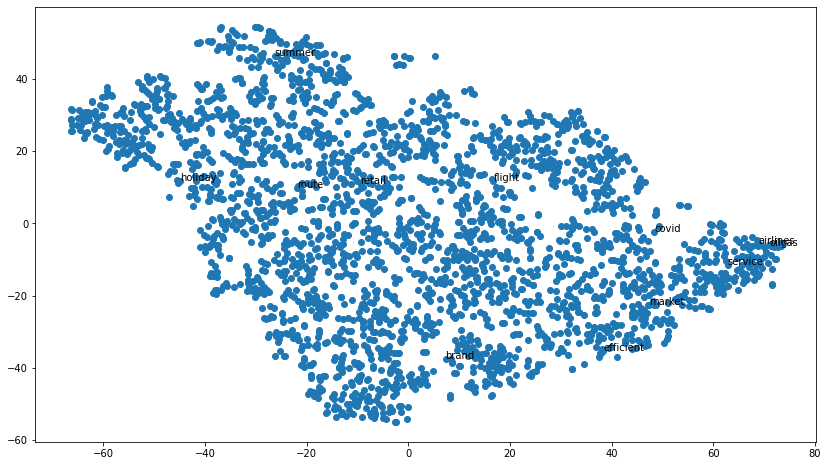

In [362]:
# Plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_new2_df['x'], scatter_new2_df['y'])

for word in label_words:
    pos = scatter_new2_df.loc[word]
    ax.annotate(word, pos)
plt.show()

In [363]:
print(model_new2.wv.most_similar(positive=["oil",'airlines','retail'],negative=["covid"],topn=5))
print(model_new2.wv.most_similar(positive=["airlines",'route','popular'],topn=5))
print(model_new2.wv.most_similar(positive=["retail",'discounts','brand'],negative=["covid"],topn=5))
print(model_new2.wv.most_similar(positive=["retail",'popular','holiday'],topn=5))
print(model_new2.wv.most_similar(positive=["oil",'technology'],topn=5))
print(model_new2.wv.most_similar(positive=["market"],negative=["covid"],topn=5))
print(model_new2.wv.most_similar(positive=["top","retail"],topn=5))
print(model_new2.wv.most_similar(positive=["top","oil"],topn=5))
print(model_new2.wv.most_similar(positive=["airlines","efficient"],negative=["oil"], topn=5))
print(model_new2.wv.most_similar(positive=["travel","oil"],negative=["shell"], topn=5))

[('earnings', 0.9930588006973267), ('total', 0.9929178953170776), ('group', 0.9925382137298584), ('call', 0.9915053844451904), ('blas', 0.991369903087616)]
[('awards', 0.9990666508674622), ('general', 0.9987079501152039), ('award', 0.9987000226974487), ('helped', 0.9986544251441956), ('growing', 0.9985716938972473)]
[('sweepstakes', 0.9982976317405701), ('adventure', 0.9982605576515198), ('hit', 0.9981131553649902), ('faster', 0.9980233907699585), ('y', 0.9979878067970276)]
[('cannot', 0.9997355937957764), ('tidytownsire', 0.9996868371963501), ('mother', 0.999677300453186), ('twice', 0.9996748566627502), ('yo', 0.9996744394302368)]
[('ltd', 0.9980696439743042), ('petrochemical', 0.9975289106369019), ('refinery', 0.9971573352813721), ('cooperation', 0.9967833161354065), ('discuss', 0.9966415166854858)]
[('don', 0.5933636426925659), ('you', 0.5848888754844666), ('do', 0.5837302207946777), ('t', 0.578216016292572), ('if', 0.5671660900115967)]
[('staff', 0.9995324015617371), ('foundation',

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
